In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((224, 224)),
    transforms.Normalize(mean=0.1307, std=0.3081)

])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


print(test_dataset[0][0].shape)

  2%|▏         | 3.74M/170M [00:08<17:10, 162kB/s]

In [23]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class SublayerConnection(nn.Module):
    def __init__(self, in_channels,out_channels,num_bns):
        super(SublayerConnection, self).__init__()
        self.relu = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(num_features=in_channels)
        self.norms = clones(nn.BatchNorm2d(num_features=out_channels), num_bns)

    def forward(self, x, sublayer,i):
        if i !=0:
            x = x + self.relu(sublayer(self.norms[i](x)))
        else:
            x =self.relu(sublayer(self.norm1(x)))

        return x

class Model(nn.Module):
    def __init__(self, in_channels, out_channels,num_conv_layers,in_features,out_features,middle_features):
        super(Model, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.sublayers = clones(SublayerConnection(in_channels,out_channels,self.num_conv_layers), self.num_conv_layers)


        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_s = clones(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),self.num_conv_layers-1)
        self.linear1 = nn.Linear(in_features=in_features, out_features=middle_features)
        self.linear2 = nn.Linear(in_features=middle_features, out_features=out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        for i in range(self.num_conv_layers):
            if i ==0:
                x = self.pool(self.sublayers[i](x,self.conv_1,i))

            else:
                x = self.pool(self.sublayers[i](x,self.conv_s[i-1],i))

        x = x.view(x.size(0), -1)
        

        x = self.dropout(self.relu(self.linear1(x)))
        return self.linear2(x)

model = Model(in_channels=3,out_channels=64,num_conv_layers=4,in_features=256,out_features=128,middle_features=10)
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()


model = model.apply(init_weights)
model = model.to(device)

In [24]:
optimizer = Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()


def train(num_epochs):
    model.train()
    losses = []
    epoches = torch.arange(1, num_epochs + 1)

    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        for idx, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            total += y.size(0)
            correct += (y_pred.argmax(dim=1) == y).sum().item()
            if (idx + 1) % 100 == 0:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}],Batches[{idx + 1}/{len(train_dataloader)}], Loss: {running_loss / ((idx + 1) * (x.size(0))):.3f} , Accuracy: {(100 * correct / total):.2f}%")
        losses.append(running_loss / len(train_dataloader.dataset))
        print(f"第{epoch + 1}轮的训练精度为：{(100 * correct / total):.2f}%\n")
    plt.plot(epoches, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


def test():
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 不计算梯度
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10],Batches[100/782], Loss: 2.666 , Accuracy: 16.81%
Epoch [1/10],Batches[200/782], Loss: 2.341 , Accuracy: 20.08%
Epoch [1/10],Batches[300/782], Loss: 2.228 , Accuracy: 21.02%
Epoch [1/10],Batches[400/782], Loss: 2.159 , Accuracy: 21.74%
Epoch [1/10],Batches[500/782], Loss: 2.108 , Accuracy: 22.50%
Epoch [1/10],Batches[600/782], Loss: 2.073 , Accuracy: 22.95%
Epoch [1/10],Batches[700/782], Loss: 2.041 , Accuracy: 23.70%
第1轮的训练精度为：24.15%

Epoch [2/10],Batches[100/782], Loss: 1.809 , Accuracy: 28.59%
Epoch [2/10],Batches[200/782], Loss: 1.786 , Accuracy: 30.04%
Epoch [2/10],Batches[300/782], Loss: 1.783 , Accuracy: 30.47%
Epoch [2/10],Batches[400/782], Loss: 1.773 , Accuracy: 31.32%
Epoch [2/10],Batches[500/782], Loss: 1.757 , Accuracy: 31.98%
Epoch [2/10],Batches[600/782], Loss: 1.745 , Accuracy: 32.62%
Epoch [2/10],Batches[700/782], Loss: 1.736 , Accuracy: 33.09%
第2轮的训练精度为：33.51%

Epoch [3/10],Batches[100/782], Loss: 1.632 , Accuracy: 37.19%
Epoch [3/10],Batches[200/782], Los

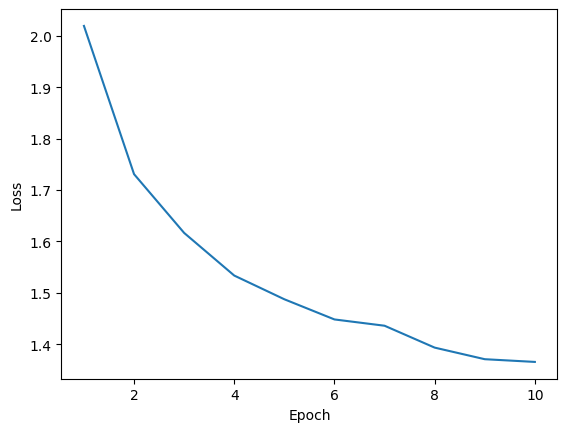

Test Accuracy: 59.66%


In [25]:
if __name__ == '__main__':
    num_epochs = 10
    train(num_epochs)
    test()